<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220815.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis
* iterator

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotnine as gg 
from plotnine import ggplot, aes 
from datetime import datetime, date, time, timezone, timedelta

import os 
import re 

from functools import reduce
from collections import defaultdict, ChainMap, Counter 
from itertools import combinations, permutations, product

# customer analysis

In [3]:
os.listdir()

['.config',
 'online_retail_II.xlsx',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'ecommerce-data.csv',
 'sample_data']

In [8]:
df = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name = 'Transactions')
df.head()

,Note: The data and information in this document is reflective of a hypothetical situation and client. This document is to be used for KPMG Virtual Internship purposes only.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701
3,3,37,402,2017-10-16 00:00:00,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361
4,4,88,3135,2017-08-31 00:00:00,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.1,36145


In [9]:
df.columns = df.loc[0]
df.drop([0], axis = 0, inplace = True)
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701
3,3,37,402,2017-10-16 00:00:00,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361
4,4,88,3135,2017-08-31 00:00:00,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.1,36145
5,5,78,787,2017-10-01 00:00:00,True,Approved,Giant Bicycles,Standard,medium,large,1765.3,709.48,42226


In [12]:
df = df[df.order_status == 'Approved']
df.transaction_date = df.transaction_date.to_numpy().astype('datetime64[ns]')
df['date'] = df.transaction_date.to_numpy().astype('datetime64[D]')
df['month'] = df['date'].to_numpy().astype('datetime64[M]')

df = df[['customer_id', 'date', 'month', 'list_price']]
df = df.rename(columns = {'customer_id':'id', 'list_price':'rev'})
df = df.groupby(['id','date','month'])['rev'].sum().reset_index()
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,date,month,rev
0,1,2017-01-05,2017-01-01,360.4
1,1,2017-02-21,2017-02-01,71.49
2,1,2017-03-27,2017-03-01,688.63
3,1,2017-03-29,2017-03-01,1274.93
4,1,2017-04-06,2017-04-01,1577.53


In [13]:
list_pu = df.groupby(['id', 'month'])['rev'].sum().reset_index().sort_values(['id','month'], ascending = [1,1])
list_npu = list_pu.groupby(['id']).first().reset_index()
list_mon = list_npu['month'].sort_values().unique()

In [14]:
for mon in list_mon : 
  temp_npu = list_npu[list_npu['month'] == mon]
  temp_pu = list_pu[list_pu['id'].isin(temp_npu['id'])]
  temp = temp_pu.groupby(['month'])['id'].count().reset_index().rename(columns = {'id':'pu'})
  temp = temp.assign(npu_month = str(mon)[:10],
                     num = temp['month'].rank(),
                     ratio = lambda x : round(x['pu']/x['pu'].max()*100,2)
                     )
  
  temp = temp[['npu_month', 'num', 'pu', 'ratio']]

  if mon == list_mon[0] :

    res = temp

  else : 

    res = pd.concat([res, temp], axis = 0)

res = pd.melt(res, id_vars = ['npu_month', 'num'], var_name = 'type')
res.head()

,npu_month,num,type,value
0,2017-01-01,1.0,pu,1347.0
1,2017-01-01,2.0,pu,483.0
2,2017-01-01,3.0,pu,505.0
3,2017-01-01,4.0,pu,499.0
4,2017-01-01,5.0,pu,492.0


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


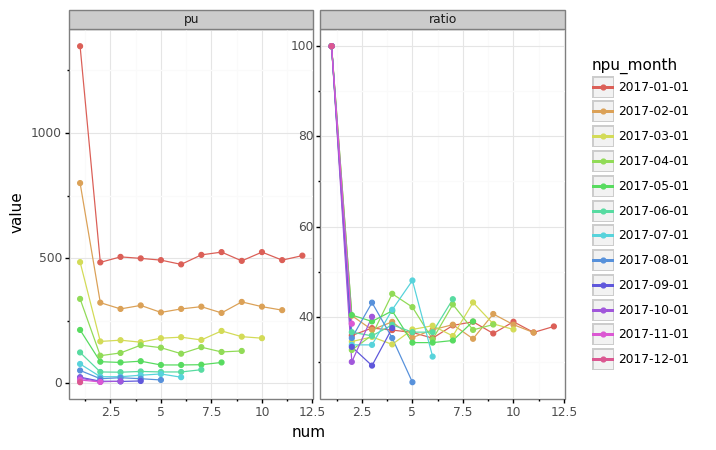

<ggplot: (8769057154449)>

In [15]:
(
    ggplot(res, aes('num', 'value', color = 'npu_month')) +
    gg.geom_line() +
    gg.geom_point() +
    gg.facet_wrap('~type', scales = 'free_y') +
    gg.theme_bw()
)

In [16]:
info_m = df.groupby(['id', 'month'])['rev'].sum().reset_index().rename(columns = {'rev':'money'})
info_m = pd.pivot_table(info_m, index = 'id', columns = 'month', values = 'money').reset_index()
info_m = pd.melt(info_m, id_vars = 'id', var_name = 'month', value_name = 'money').reset_index().sort_values(['id','month'], ascending = [1,0])
info_m = info_m.groupby(['id']).head(3)
info_m = info_m.groupby('id')['money'].sum().reset_index()
info_m.head()

,id,money
0,1,1209.08
1,2,0.00
2,3,0.00
3,4,0.00
4,5,1812.75


In [17]:
info_f = df.groupby(['id', 'month'])['rev'].count().reset_index().rename(columns = {'rev':'freq'})
info_f = pd.pivot_table(info_f, index = 'id', columns = 'month', values = 'freq').reset_index()
info_f = pd.melt(info_f, id_vars = 'id', var_name = 'month', value_name = 'freq').reset_index().sort_values(['id','month'], ascending = [1,0])
info_f = info_f.groupby(['id']).head(3)
info_f = info_f.groupby('id')['freq'].sum().reset_index()
info_f.head()

,id,freq
0,1,3.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,1.0


In [18]:
date_max = (df['date'] + pd.offsets.MonthEnd(0)).max()
date_max

Timestamp('2017-12-31 00:00:00')

In [19]:
info_r = df.groupby(['id']).agg({'date' : lambda x : (date_max - x.max()).days}).reset_index().rename(columns = {'date':'recency'})
info_r.head()

,id,recency
0,1,8
1,2,129
2,3,103
3,4,196
4,5,17


In [21]:
info = pd.merge(pd.merge(info_r, info_f, 'left', 'id'), info_m, 'left', 'id')
info = info.assign(r = pd.qcut(info.recency, 5, list('54321')),
                   f = pd.qcut(info.freq.rank(method = 'first'), 5, list('12345')),
                   m = pd.qcut(info.money.rank(method = 'first'), 5, list('12345'))
                   )
info['fm'] = info.r.astype(str) + info.f.astype(str)
info.head()

,id,recency,freq,money,r,f,m,fm
0,1,8,3.0,1209.08,5,5,3,55
1,2,129,0.0,0.00,1,1,1,11
2,3,103,0.0,0.00,1,1,1,11
3,4,196,0.0,0.00,1,1,1,11
4,5,17,1.0,1812.75,4,2,4,42


# iterator

In [22]:
mat = [list('ABC'), list('DEF'), list('GHI')]
for r, rows in enumerate(mat) :
  for c, letters in enumerate(rows) : 
    print(f'({r},{c})-{letters}')

(0,0)-A
(0,1)-B
(0,2)-C
(1,0)-D
(1,1)-E
(1,2)-F
(2,0)-G
(2,1)-H
(2,2)-I


In [23]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'age': 73,
  'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M'},
 {'age': 29,
  'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F'},
 {'age': 51,
  'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M'},
 {'age': 32,
  'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F'},
 {'age': 42, 'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F'}]

In [24]:
for key in list(users[0].keys()) :
  if key == list(users[0].keys())[0] :
    res = eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])')
  else : 
    res = np.c_[res, eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])')]
res

array([['gregorythomas@gmail.com', 'Brett Holland', 'M', '73'],
       ['hintoncynthia@hotmail.com', 'Madison Martinez', 'F', '29'],
       ['wwagner@gmail.com', 'Michael Jenkins', 'M', '51'],
       ['daniel79@gmail.com', 'Karen Rodriguez', 'F', '32'],
       ['ujackson@gmail.com', 'Amber Rhodes', 'F', '42']], dtype='<U25')

In [25]:
{key : eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])') for key in list(users[0].keys())}

{'age': [73, 29, 51, 32, 42],
 'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F']}

In [28]:
a = defaultdict(list)
for wow in users :
  for k,v in wow.items() :
    a[k].append(v)
a

defaultdict(list,
            {'age': [73, 29, 51, 32, 42],
             'mail': ['gregorythomas@gmail.com',
              'hintoncynthia@hotmail.com',
              'wwagner@gmail.com',
              'daniel79@gmail.com',
              'ujackson@gmail.com'],
             'name': ['Brett Holland',
              'Madison Martinez',
              'Michael Jenkins',
              'Karen Rodriguez',
              'Amber Rhodes'],
             'sex': ['M', 'F', 'M', 'F', 'F']})